# In DEMO1, text-based preparing procedures of PEDOT-PSS will be converted to graphs and treated by a graph neural net to predict electric conductivity
- step0: text was converted to graphs by natural language parser
- step1: graph databases are cleaned and formatted
- step2: graph databases will be converted to adjacency matrixes and node vectors for ML
- step3: ML is done with a graph neural net

## This script will prepare graphs from text of PEDOT-PSS


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import re
import os
from tqdm import tqdm
import joblib
import numpy as np
import joblib
import stanfordnlp

os.chdir("praparingGraphs")

# Firstly, load text 
- load preparation procedure of PEDOT-PSS films

In [12]:
path="20200227pedotPSS.txt"

#load processing data
with open(path) as f:
    txt = f.read()
txt=txt.replace("\n","")

#preprocessing some words (this was temporality done because nlp parser splits two nodes from the phrases, wghich is not appreciated)
#TODO: this first aid is far from elegant
txt=txt.replace("electric conductivity","electricconductivity")
txt=txt.replace("S/cm","Scm")
txt

'#ID1#commentP001Fig1_1#texta mixture (1.3 weight percent of C0001 ("PH_thousand") and 98.7 weight percent of C0002) was spincoated,which was kept for 15 minutes at 120 Celsius,to which a mixture (0.0770 weight percent of C0004 and 99.92 weight percent of C0002) was dropped,which was kept for 5 minutes at 140 Celsius,which was rinsed by C0002,which was kept for 5 minutes at 140 Celsius,which gave an electricconductivity (197.15 Scm)#ID2#commentP001Fig1_2#texta mixture (1.3 weight percent of C0001 ("PH_thousand") and 98.7 weight percent of C0002) was spincoated,which was kept for 15 minutes at 120 Celsius,to which a mixture (14.84 weight percent of C0004 and 85.13 weight percent of C0002) was dropped,which was kept for 5 minutes at 140 Celsius,which was rinsed by C0002,which was kept for 5 minutes at 140 Celsius,which gave an electricconductivity (533 Scm)#ID3#commentP001Fig1_3#texta mixture (1.3 weight percent of C0001 ("PH_thousand") and 98.7 weight percent of C0002) was spincoated,wh

# calculate z-score of numbers
- calculations were done for each unit (S/cm, etc)
- conductivity was converted in a log scale

In [13]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

rePhrase='[ |\(]\d+(?:\.\d+)? \w*'

#extract the followng phrases: " number unit" or "(number unit"
numPlusUnit=re.findall(rePhrase, txt) 
numPlusUnit=[i[1:] for i in numPlusUnit]

df=pd.DataFrame(numPlusUnit)
df=df[0].str.split(" ",expand=True)

unitList=list(set(df[1]))

#fit
scalingDict={}
for unit in unitList:
    scaler = StandardScaler()
    
    valList=df[df[1]==unit][0].values
    valList=np.array([float(i) for i in valList])
    
    
    if unit=="Scm":
        valList=np.log10(valList)
        
    scalingDict[unit]=scaler.fit(valList.reshape(-1,1))
    
#make dict of scaling
joblib.dump(scalingDict,"scalingDictForPEDOTPSS.bin")

['scalingDictForPEDOTPSS.bin']

In [19]:
%%time
#transforming

modifTxt=txt
txtIndex=0

for i in range(len(txt)):

    match=re.search(rePhrase, modifTxt[txtIndex:]) 
    
    try:
        matchTxt=match.group()[1:]
    except:
        break
        

    #calculate z-score
    val,unit=matchTxt.split()
    val=np.array([float(val)])
    
    if unit=="Scm":
        val=np.log10(val)
    
    zval=scalingDict[unit].transform(val.reshape(1,-1))[0][0]
    zval=round(zval, 5)
    
    #replace text
    repText=str(zval)+ " " + unit
    #print(match.group(),repText)

    modifTxt=modifTxt[:match.start()+1+txtIndex]+repText+modifTxt[match.end()+txtIndex:]
    txtIndex=txtIndex+match.start()+len(repText)




Wall time: 181 ms


# parsing by NLP and preparing graphs

In [35]:
#split text by each ID
IDList = re.findall('#ID(.+?)#comment', modifTxt)
textList=re.findall('#text(.+?)#ID', modifTxt)

#saving
with open("textList.bin", mode="wb") as f:
    joblib.dump(textList, f, compress=9)

In [36]:
#utility funcs for processing...

def is_num(s):
    try:
        float(s)
    except ValueError:
        return False
    else:
        return True


#make graphs from text
def graphFromText(text,sentenceNum=0):
    
    #parsing
    doc = nlp(text)
    sentence=doc.sentences[sentenceNum]
    dependencyArray=[[words.index,words.text,words.governor] for words in sentence.words]


    idList,txtList,depList=list(zip(*dependencyArray))
    idList=["node"+str(i) for i in idList]
    depList=["node"+str(i) for i in depList]

    edgeList=list(zip(idList,depList))


    g=nx.Graph()
    for edge in edgeList:
        g.add_edge(edge[0],edge[1])

    for ind,txt in zip(idList,txtList):
        g.add_node(ind,label=txt)

    g.add_node("node0",label=".")
    
    return g


#manually delete trivial nodes
def deleteTrivialNodes(g):
    delList=["at","were","and",",",".",
             "was","by","to","(",")","an",
            "which","of","a","for","in","\"",
            ]

    for nodeName in list(g.nodes):
        if len(list(g.neighbors(nodeName)))==1:
            nodeLabel=g.nodes[nodeName]["label"]
            if nodeLabel in delList:
                g.remove_node(nodeName)
    return g

#finalizing
def finalizeProcessGraph(g):
    #manually recover electricconductivity and Scm
    for nodeName in list(g.nodes):
        nodeLabel=g.nodes[nodeName]["label"]
        if nodeLabel=="electricconductivity":
            g.nodes[nodeName]["label"]="electric conductivity"
        elif nodeLabel=="Scm":
            g.nodes[nodeName]["label"]="[S/cm]"
            
    #compound node values: from 1234 to C_C1234
    for nodeName in list(g.nodes):
        nodeLabel=g.nodes[nodeName]["label"]
        if re.search("C[0-9]{4}", nodeLabel):
            g.nodes[nodeName]["label"]=nodeLabel.replace("C","C_C")            
    return g
    
#draw graph
def drawGraph(g,drawLabel=True,printNodes=False):
    pos = nx.spring_layout(g, k=0.1)
    plt.figure(3,figsize=(30,30)) 

    if drawLabel:
        gDict={}
        for node in g.nodes:
            gDict[node]=g.nodes[node]["label"]

        plt.figure(1,figsize=(12,12)) 
        nx.draw(g,with_labels = True, alpha=0.8,labels=gDict,font_size=15,node_size=100) #NEW FUNCTION

    else:
        nx.draw(g,pos, with_labels = True)


    if printNodes:
         for node in g.nodes:
            print(node,"  ",g.nodes[node]["label"])       

In [38]:
stanfordnlp.download('en')

Using the default treebank "en_ewt" for language "en".
Would you like to download the models for: en_ewt now? (Y/n)


 Y



Default download directory: C:\Users\tkojima\stanfordnlp_resources
Hit enter to continue or type an alternate directory.



Download location: C:\Users\tkojima\stanfordnlp_resources\en_ewt_models.zip


100%|███████████████████████████████████████████████████████████████████████████████| 235M/235M [00:52<00:00, 4.48MB/s]



Download complete.  Models saved to: C:\Users\tkojima\stanfordnlp_resources\en_ewt_models.zip
Extracting models file for: en_ewt
Cleaning up...Done.


In [39]:
#init parser
nlp = stanfordnlp.Pipeline(processors= "tokenize,pos,depparse")

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': 'C:\\Users\\tkojima\\stanfordnlp_resources\\en_ewt_models\\en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': 'C:\\Users\\tkojima\\stanfordnlp_resources\\en_ewt_models\\en_ewt_tagger.pt', 'pretrain_path': 'C:\\Users\\tkojima\\stanfordnlp_resources\\en_ewt_models\\en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: depparse
With settings: 
{'model_path': 'C:\\Users\\tkojima\\stanfordnlp_resources\\en_ewt_models\\en_ewt_parser.pt', 'pretrain_path': 'C:\\Users\\tkojima\\stanfordnlp_resources\\en_ewt_models\\en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Done loading processors!
---


In [41]:
#text to graphs
graphList=[]
for text in tqdm(textList):
    g=graphFromText(text,0)
    g=deleteTrivialNodes(g)
    g=finalizeProcessGraph(g)
    graphList.append(g)
    

  0%|                                                                                          | 0/340 [00:00<?, ?it/s]C:\Users\tkojima\anaconda3\lib\site-packages\stanfordnlp\models\depparse\model.py:157: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:921.)
  unlabeled_scores.masked_fill_(diag, -float('inf'))
100%|████████████████████████████████████████████████████████████████████████████████| 340/340 [01:17<00:00,  4.36it/s]


In [46]:
#save
with open("input/autoPEDOTPSS/PEDOT_PSS_autoprocessedGraph.graphbin", mode="wb") as f:
    joblib.dump(graphList, f, compress=3)

# check graphs!

In [50]:
len(graphList)

340

In [63]:
[g.number_of_nodes() for g in graphList]

[47,
 47,
 47,
 46,
 47,
 47,
 38,
 39,
 39,
 38,
 38,
 38,
 38,
 38,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 48,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 39,
 38,
 39,
 38,
 39,
 38,
 39,
 38,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 44,
 44,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 45,
 44,
 44,
 44,
 44,
 44,
 45,
 45,
 44,
 44,
 44,
 44,
 44,
 42,
 50,
 50,
 50,
 50,
 41,
 32,
 32,
 32,
 31,
 31,
 32,
 32,
 32,
 31,
 31,
 32,
 32,
 32,
 32,
 44,
 44,
 44,
 44,
 76,
 76,
 49,
 48,
 48,
 39,
 40,
 39,
 39,
 39,
 23,
 28,
 28,
 28,
 27,
 28,
 28,
 26,
 26,
 26,
 26,
 22,
 27,
 27,
 27,
 26,
 26,
 26,
 26,
 26,
 23,
 23,
 29,
 23,
 23,
 23,
 29,
 29,
 29,
 29,
 29,
 23,
 23,
 29,
 29,
 27,
 27,
 27,
 27,
 27,
 27,
 35,
 42,
 42,
 42,
 42,
 41,
 29,
 36,
 35,
 35,
 35,
 35,
 35,
 29,
 36,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 45,
 45,
 45,
 45,
 45,


<Figure size 2160x2160 with 0 Axes>

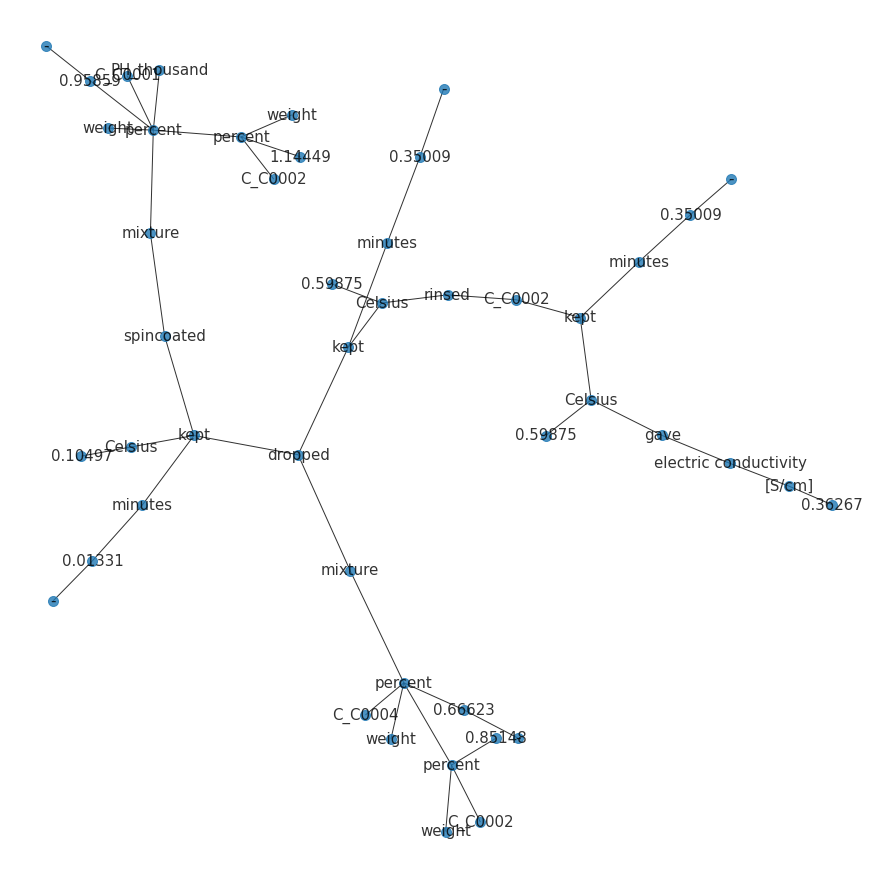

In [55]:
drawGraph(graphList[1])